In [1]:
import torch
from SunAttributeDataset import SunAttributeDataset
from torch.autograd import Variable
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import OrderedDict
import os
from resnet import resnet101
import matplotlib
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy.io import loadmat
from sklearn.metrics.pairwise import cosine_similarity

img_path = '/media/drive1/Data/Sun_attri/SUNAttributeDB/images.mat'
attri_path = '/media/drive1/Data/Sun_attri/SUNAttributeDB/attributeLabels_continuous.mat'
root_dir = '/media/drive1/Data/Sun_attri/images/'
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
d = SunAttributeDataset(img_path, attri_path, root_dir, transform_train)

In [2]:
# load pretrained model
path = os.path.join(os.getcwd(), 'checkpoint', 'best_classifi_95.57.pth')


tnet = torch.load(path)
net = resnet101()
# load backbone resnet for comparison
net2 = resnet101()

net.fc = nn.Linear(2048, 611)
net2.fc = nn.Linear(2048, 611) 

new_state_dict = OrderedDict()                                                                                                                                                                           
for value in tnet['state_dict']:                                                                                                                                                  
    key = value.replace("module.", "")
    value = tnet['state_dict'][value]  
    new_state_dict[key] = value
    
net.load_state_dict(new_state_dict)
net = net.eval().cuda()
net2 = net2.eval().cuda()

In [6]:
batch_size = 8
train_loader = torch.utils.data.DataLoader(d, batch_size=8, shuffle=False)

In [4]:
# Compute all the features and stored in the format of (img: features)
count = 0
f = []
f2 = []
print('Loading and computing the testing features, this may take several minutes...')
for batch_idx, (inputs, targets, attribute) in enumerate(train_loader):
    inputs, targets, attribute = inputs.cuda(async=True), targets.cuda(async=True), attribute.cuda(async=True)
    inputs = Variable(inputs)
    targets = Variable(targets).long()
    attribute = Variable(attribute).float()
    outputs, feat = net(inputs)
    outputs2, feat2 = net2(inputs)

    f.append(feat.data.cpu().numpy())
    f2.append(feat2.data.cpu().numpy())
    count += 1


Loading and computing the testing features, this may take several minutes...


In [7]:
ft = np.zeros([14340, 2048])
ft2 = np.zeros([14340, 2048])

count = 0
for count in range(897):
    if f[count].shape[0] is not batch_size:
        ft[count*batch_size: count*batch_size + f[count].shape[0]] = f[count]
        ft2[count*batch_size: count*batch_size + f[count].shape[0]] = f2[count]

    else:
        ft[count*batch_size: (count+1)*batch_size] = f[count]
        ft2[count*batch_size: (count+1)*batch_size] = f2[count]


In [8]:
def retrieval_img(m, ft):
    feat1 = ft[m].reshape(1,-1)
    result = []
    for i in range(ft.shape[0]):
        if i is not m:
            s = cosine_similarity(feat1, ft[i].reshape(1,-1))[0][0]
            result.append(s)
    return sorted(range(len(result)), key=lambda i: result[i])[-15:]

In [9]:
def display_img_withindex(indexs):
    images = []
    img_paths = loadmat(img_path)['images']
    for index in indexs:
        path = root_dir + img_paths[index][0][0]
        print(path)
        img = Image.open(path)
        images.append(np.asarray(img))
    return images

### Select on query image, index range from 0 to 14000

In [15]:
index = 222
result = retrieval_img(index, ft)
result2 = retrieval_img(index, ft2)

images = display_img_withindex(result)
print('regular network:')
images2 = display_img_withindex(result2)

plt.figure(figsize=(3,3))

/media/drive1/Data/Sun_attri/images/a/amphitheater/sun_abwqzffqknkgrsha.jpg
/media/drive1/Data/Sun_attri/images/a/amphitheater/sun_akmquezkopkgqsid.jpg
/media/drive1/Data/Sun_attri/images/a/amphitheater/sun_addrqcoigwfbrtii.jpg
/media/drive1/Data/Sun_attri/images/a/amphitheater/sun_ajfjbafrlzzbmzoj.jpg
/media/drive1/Data/Sun_attri/images/a/amphitheater/sun_aehqbvxyjluttouv.jpg
/media/drive1/Data/Sun_attri/images/a/amphitheater/sun_ahgyshdgrnujgqkx.jpg
/media/drive1/Data/Sun_attri/images/f/fortress/sun_bpnzrmjzioxokjfv.jpg
/media/drive1/Data/Sun_attri/images/a/amphitheater/sun_amtygraxxiwprrrm.jpg
/media/drive1/Data/Sun_attri/images/a/amphitheater/sun_amjtnmmfueunrlcj.jpg
/media/drive1/Data/Sun_attri/images/a/amphitheater/sun_ajlkthvuowdwxgyb.jpg
/media/drive1/Data/Sun_attri/images/a/amphitheater/sun_aloaoimycyukbexq.jpg
/media/drive1/Data/Sun_attri/images/a/amphitheater/sun_aezcgczhwucnpnxa.jpg
/media/drive1/Data/Sun_attri/images/a/amphitheater/sun_aecfkbdezqiwwwhp.jpg
/media/drive1/Da

### Display the query image

/media/drive1/Data/Sun_attri/images/a/amphitheater/sun_abjehdgjnkljkvds.jpg


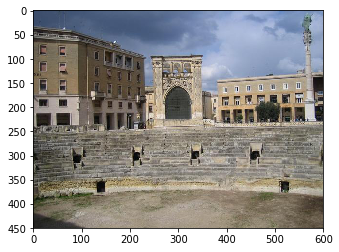

In [11]:
plt.imshow(display_img_withindex([index])[0])

### Display the retrieved image

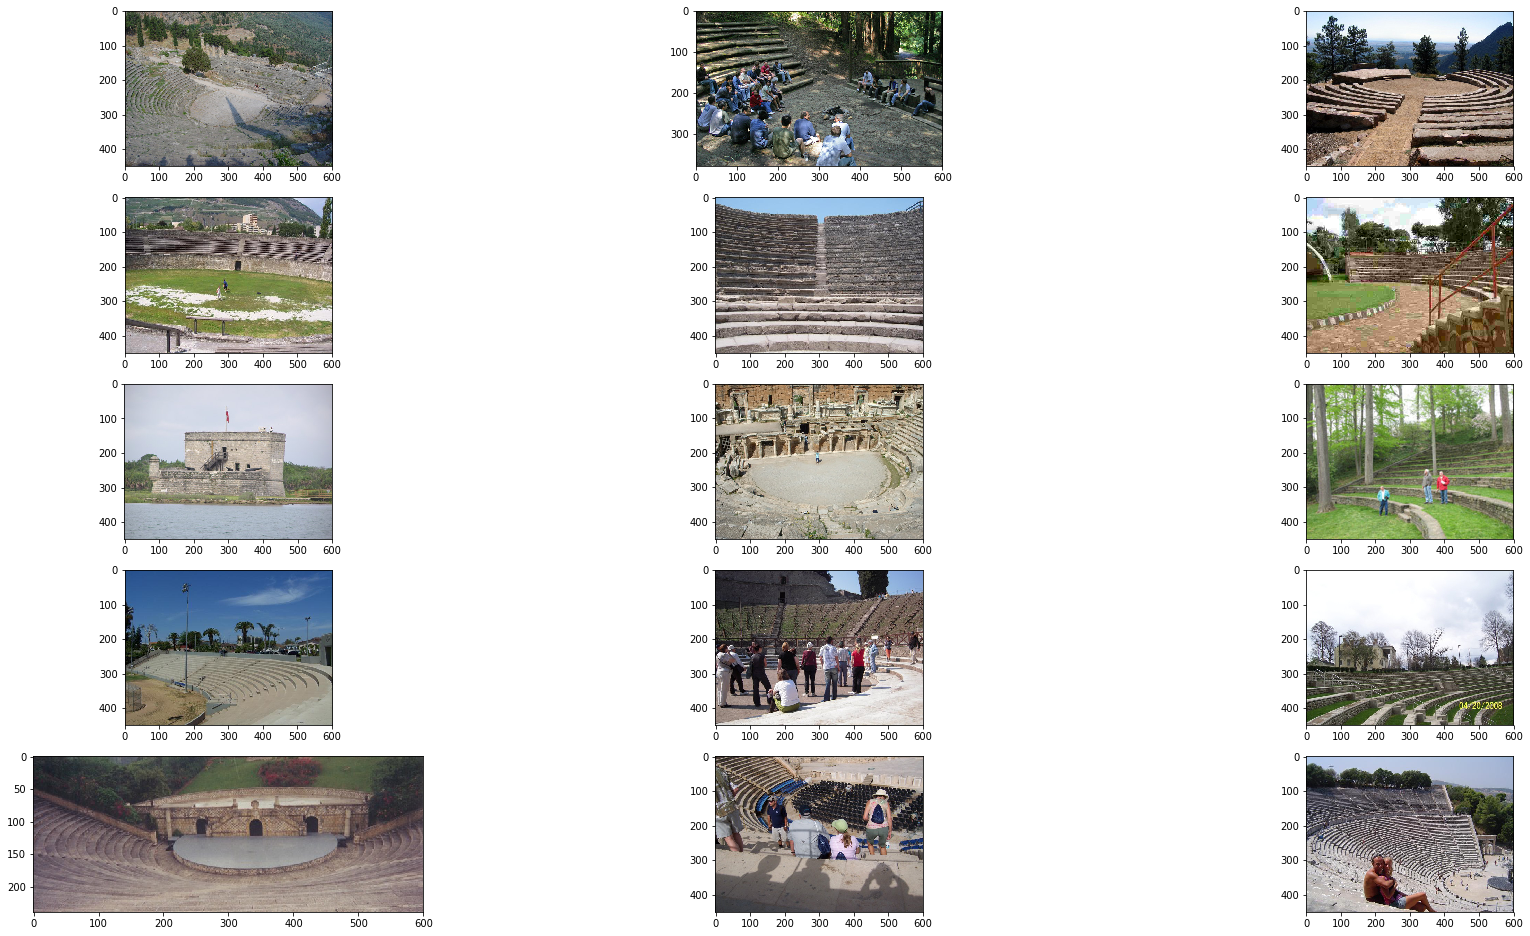

In [12]:
# retrieved by joint training
plt.figure(figsize=(30,20))
columns = 3
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

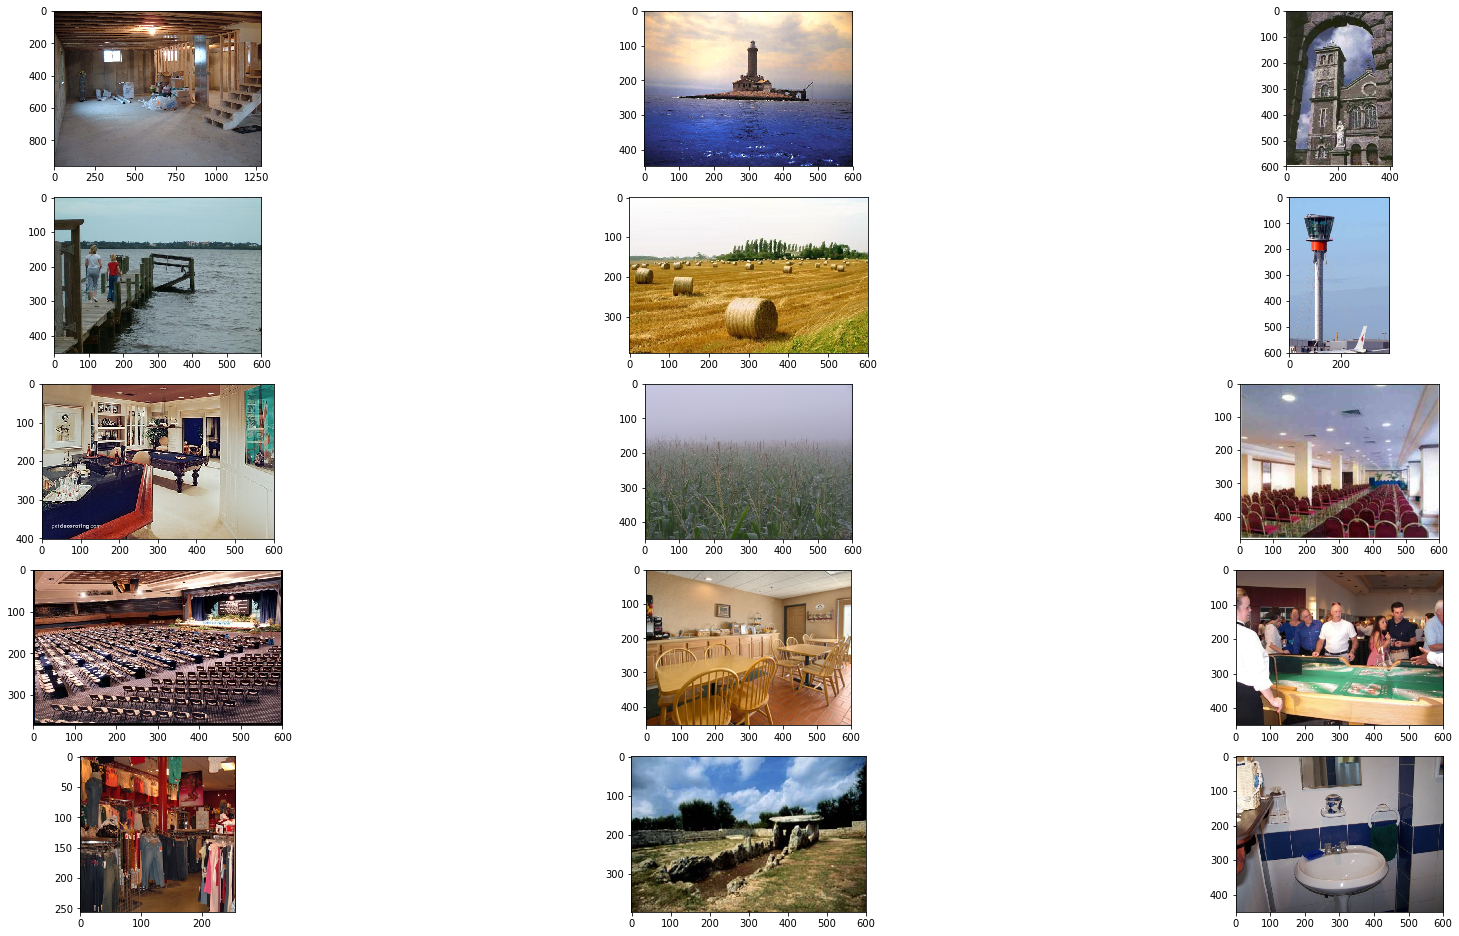

In [16]:
# retrieved by pretrained res101

plt.figure(figsize=(30,20))
columns = 3
for i, image in enumerate(images2):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)